In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from scipy.stats import pearsonr
from sklearn.model_selection import ParameterSampler
import joblib

# metadata
ann_tcga = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
hrd_scores = pd.read_excel('../data/tcga.hrdscore.xlsx', index_col=0)

# rnaseq versions
fpkm = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
deconvo = pd.read_csv('../data/Deconvo2.csv',  index_col=0)
tpm = pd.read_csv('../data/tpm.csv', index_col=0, low_memory=False)

# ann_tcga[ann_tcga['event.PALB2'].ne('0')]
# ann_tcga[ann_tcga['event.RAD51C'].ne('0')]
metadata = ann_tcga[~ann_tcga['event.RAD51C'].ne('0')]
metadata = metadata[~metadata['event.PALB2'].ne('0')]
metadata = metadata[metadata['event.BRCA1'] != '1']
metadata.index = metadata.index.str.replace('.', '-', regex=False)
hrd_scores.index = hrd_scores.index.map(lambda x: x[:12])
metadata = metadata.merge(hrd_scores[['HRD-sum']], left_index=True, right_index=True, how='inner')


fpkm = fpkm.set_index('Case ID')
fpkm = fpkm[fpkm['Sample Type'] == 'Primary Tumor']
fpkm = fpkm.drop(columns=["Sample ID","Sample Type"])


dick = {}
for i, v in enumerate(fpkm.columns):
    # print(i,v)
    dick[v.split('|')[0]] =v.split('|')[1]
tpm = tpm.rename(columns=dick)
tpm = tpm[~tpm.index.duplicated(keep='first')]

# Keeps only Primary Tumor
tpm = tpm.loc[tpm.index.str[13:15] == "01"]

# deconvo = deconvo.sort_index()
# deconvo = np.log2(deconvo + 1)
fpkm.columns = [col.split('|')[1] if '|' in col else col for col in fpkm.columns]
fpkm.index = fpkm.index.map(lambda x: x[:12])
fpkm = fpkm.loc[fpkm.index.intersection(metadata.index)]
fpkm.sort_index(inplace=True)
fpkm = fpkm.rename_axis("fpkm", axis="index")
fpkm = fpkm.apply(pd.to_numeric, errors='coerce')
fpkm.fillna(0, inplace=True)

deconvo.index = deconvo.index.map(lambda x: x[:12])
deconvo = deconvo.loc[deconvo.index.intersection(metadata.index)]
deconvo.sort_index(inplace=True)
deconvo = deconvo.rename_axis("deconvo", axis="index")
deconvo.fillna(0, inplace=True)

tpm.index = tpm.index.map(lambda x: x[:12])
tpm = tpm.loc[tpm.index.intersection(metadata.index)]
tpm.sort_index(inplace=True)
tpm = tpm.rename_axis("tpm", axis="index")
tpm = tpm.apply(pd.to_numeric, errors='coerce')
tpm.fillna(0, inplace=True)



print(f"fpkm shape{fpkm.shape}")
print(f"deconvo shape{deconvo.shape}")
print(f"tpm shape{tpm.shape}")


# plt.figure(figsize=(10, 6))
# sns.histplot(data=metadata, x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
# plt.title('Histogram of HRD-sum with PAM50 Subtypes')
# plt.xlabel('HRD-sum')
# plt.ylabel('Frequency')
# plt.show()
pam50_counts = metadata['event.PAM50'].value_counts()
print(pam50_counts)


def downsampling_lumA(metadata, lumA_cutoff):
    lumA_HRD = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] >= lumA_cutoff)]
    lumA_HRP = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] < lumA_cutoff)]
    # print(lumA_HRP.shape, lumA_HRD.shape)
    if lumA_HRP.shape[0] < lumA_HRD.shape[0]:
        print(f"Not enough HRP samples ({lumA_HRP.shape[0]}) to match HRD count ({lumA_HRD.shape[0]}). Skipping downsampling.")
        return metadata, pd.DataFrame()
    lumA_HRP_downsampled = lumA_HRP.sample(n=lumA_HRD.shape[0], random_state=42)
    df_downsampled = pd.concat([lumA_HRD, lumA_HRP_downsampled])
    df_downsampled = pd.concat([df_downsampled, metadata[metadata['event.PAM50'] != 'LumA']])
    # print(df_downsampled['event.PAM50'].value_counts())
    print(f"number of samples left: {df_downsampled.shape}")
    unused_majority = lumA_HRP.loc[~lumA_HRP.index.isin(lumA_HRP_downsampled.index)]
    return df_downsampled, unused_majority

# df_downsampled, removed_samples = downsampling_lumA(metadata, 23)

def add_back_test(rna_df, removed_samples, X_test,y_test):
    add_back_features = rna_df.loc[rna_df.index.intersection(removed_samples.index)]
    add_back_features = add_back_features.sort_index()

    add_back_y = removed_samples.loc[removed_samples.index.intersection(rna_df.index)]
    add_back_y = add_back_y.sort_index()

    X_test = pd.concat([X_test, add_back_features])
    y_test = pd.concat([y_test, add_back_y['HRD-sum'].squeeze()])
    return X_test, y_test

# X_test,y_test = add_back_test(deconvo, removed_samples, X_test, y_test)

def sigmoid_transform(values, shift=0, scale=1):
    return 1 / (1 + np.exp(-scale * (values - shift)))
def binary_hrd(values, threshold):
    return (values >= threshold).astype(int)

def plot_test_train_pam50_dist(metadata, X_train, X_test):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_test.index)], x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Test Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_train.index)], x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Train Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

    # pam50_counts = df_downsampled['event.PAM50'].value_counts()
    # print(pam50_counts)
    # print(df_downsampled.shape)
# plot_test_train_pam50_dist(metadata, X_train, X_test)



alphas = [0.01, 0.1, 0.25, 0.5, 1.0]
l1_ratios = [0.1, 0.5, 0.7, 0.9]
rna_seqs = [deconvo, tpm, fpkm]
downsample = [(True, False),(True,False), (False,False)]
downsample_thresholds = [x for x in range(10, 80, 5)]
softlabels = ["None", "Sigmoid", "Binary"]
softlabel_thresholds = [x for x in range(10, 80, 5)]
softlabel_gradients = np.arange(0, 1, 0.1)
normalization = ['StandardScaler','log2','None']



best_model = None
best_metrics = {'Mean Squared Error': float('inf'), 'R^2 Score': -float('inf')}
best_params = {}

# Grid search
param_distributions = {'alpha': alphas, 'l1_ratio': l1_ratios,
                            'rna-seq': rna_seqs, 'downsample': downsample,
                            'downsample_thresholds': downsample_thresholds,'softlabels': softlabels,
                            'softlabel_thresholds': softlabel_thresholds, 'softlabel_gradients': softlabel_gradients,
                            'normalization': normalization}





fpkm shape(887, 60660)
deconvo shape(835, 9853)
tpm shape(887, 60660)
event.PAM50
LumA     464
LumB     193
Basal    146
Her2      74
Name: count, dtype: int64


In [8]:
n_iter = 50  # You can adjust this value based on your computational resources

# Generate random combinations of parameters
random_params = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=42))

def get_variable_name(var):
    conv = {deconvo:'deconvo', tpm:'tpm', fpkm:'fpkm'}
    return conv[var]

In [ ]:

for iteration, params in enumerate(random_params):
    # print(params)
    # print(iteration, end=' ')
    # print({k: (v.index.name if k == 'rna-seq' else v) for k, v in params.items()})
    
    # Split data into training and test sets and get intersecting indices
    features_df = params['rna-seq']

    metadata_truncated = metadata.loc[metadata.index.intersection(features_df.index)]
    # features_df = features_df.loc[features_df.index.intersection(metadata_truncated.index)]

    labels_df = metadata_truncated['HRD-sum']
    labels_df = labels_df.sort_index()
    features_df = features_df.sort_index()

    if params['normalization'] == 'StandardScaler':
        scaler = StandardScaler()
        features_df = pd.DataFrame(scaler.fit_transform(features_df), index=features_df.index, columns=features_df.columns)
    elif params['normalization'] == 'log2':
        features_df = np.log2(features_df + 1)

    # Apply soft labels
    if params['softlabels'] == "Sigmoid":
        labels_df = sigmoid_transform(labels_df, params['softlabel_thresholds'], params['softlabel_gradients'])
    elif params['softlabels'] == "Binary":
        labels_df = binary_hrd(labels_df, params['softlabel_thresholds'])


    # Downsample LumA samples
    if params['downsample'][0]:
        df_downsampled, removed_samples = downsampling_lumA(metadata_truncated, params['downsample_thresholds'])
        features_df = features_df.loc[features_df.index.intersection(df_downsampled.index)]
        labels_df = df_downsampled.loc[df_downsampled.index.intersection(features_df.index), 'HRD-sum']
    labels = labels_df.squeeze()

    #TEST TRAIN SPLIT
    X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)
    
    if params['downsample'][1]:
        X_test,y_test = add_back_test(features_df, removed_samples, X_test, y_test)
        
    
    model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Update best model if current is better
    # if mse < best_metrics['Mean Squared Error']:
    if mse < best_metrics['Mean Squared Error'] or (mse == best_metrics['Mean Squared Error'] and r2 > best_metrics['R^2 Score']):
        best_model = model
        best_metrics = {'Mean Squared Error': mse, 'R^2 Score': r2}
        best_params = params
        best_X_train = X_train
        best_X_test = X_test
    if iteration % 100 == 0:
        print(iteration, end=' ')
        print({k: (v.index.name if k == 'rna-seq' else v) for k, v in best_params.items()})
        joblib.dump(best_model, 'model.joblib')
        y_pred_best = best_model.predict(X_test)
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred_best, alpha=0.6, label='Predicted vs Actual')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Elastic Net Regression: Predicted vs Actual (Best Model)')
        plt.legend(loc="upper left")
        plt.savefig("plot_output.png")
        
# Scatter plot of predictions vs actual values for the best model
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Elastic Net Regression: Predicted vs Actual (Best Model)')
plt.legend(loc="upper left")
plt.show()
plot_test_train_pam50_dist(metadata, best_X_train, best_X_test)
print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error: {best_metrics['Mean Squared Error']:.3f}")
print(f"R^2 Score: {best_metrics['R^2 Score']:.3f}")

# return best_model, best_metrics, best_params
elastic_model = best_model
metrics = best_metrics
params = best_params
joblib.dump(best_model, 'model.joblib')


number of samples left: (463, 34)
number of samples left: (451, 34)
number of samples left: (781, 34)
number of samples left: (463, 34)
number of samples left: (493, 34)
number of samples left: (487, 34)
number of samples left: (427, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.053e+03, tolerance: 1.721e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.926e+01, tolerance: 1.534e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

number of samples left: (475, 34)
number of samples left: (781, 34)
number of samples left: (563, 34)
number of samples left: (441, 34)
number of samples left: (475, 34)
number of samples left: (475, 34)
number of samples left: (441, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.202e+02, tolerance: 1.627e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+02, tolerance: 1.530e+01
  model = cd_fast.enet_coordinate_descent(


number of samples left: (487, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e+02, tolerance: 2.711e+01
  model = cd_fast.enet_coordinate_descent(


number of samples left: (475, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.580e+01, tolerance: 1.746e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.692e+01, tolerance: 1.746e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

number of samples left: (441, 34)
number of samples left: (463, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e+03, tolerance: 1.627e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.093e+02, tolerance: 1.465e+01
  model = cd_fast.enet_coordinate_descent(


number of samples left: (423, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.187e-01, tolerance: 1.430e-02
  model = cd_fast.enet_coordinate_descent(


number of samples left: (457, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.213e+01, tolerance: 1.449e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.429e+02, tolerance: 1.746e+01
  model = cd_fast.enet_coordinate_descent(


number of samples left: (409, 34)
number of samples left: (427, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.634e+02, tolerance: 1.371e+01
  model = cd_fast.enet_coordinate_descent(


number of samples left: (719, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.486e+02, tolerance: 1.459e+01
  model = cd_fast.enet_coordinate_descent(


number of samples left: (675, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.313e+01, tolerance: 1.509e+01
  model = cd_fast.enet_coordinate_descent(


number of samples left: (563, 34)
number of samples left: (529, 34)
number of samples left: (447, 34)
Not enough HRP samples (169) to match HRD count (295). Skipping downsampling.


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.250e+01, tolerance: 1.720e+01
  model = cd_fast.enet_coordinate_descent(


number of samples left: (833, 34)
Not enough HRP samples (169) to match HRD count (295). Skipping downsampling.
number of samples left: (781, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.587e-01, tolerance: 1.165e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 9.377e-03
  model = cd_fast.enet_coordinate_descent(


number of samples left: (529, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e+03, tolerance: 1.956e+01
  model = cd_fast.enet_coordinate_descent(


number of samples left: (493, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e+03, tolerance: 2.711e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.175e+02, tolerance: 1.720e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

number of samples left: (601, 34)
number of samples left: (475, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.955e+02, tolerance: 2.050e+01
  model = cd_fast.enet_coordinate_descent(


number of samples left: (475, 34)
number of samples left: (427, 34)


/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.448e+01, tolerance: 1.509e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e+03, tolerance: 3.220e+01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrd/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

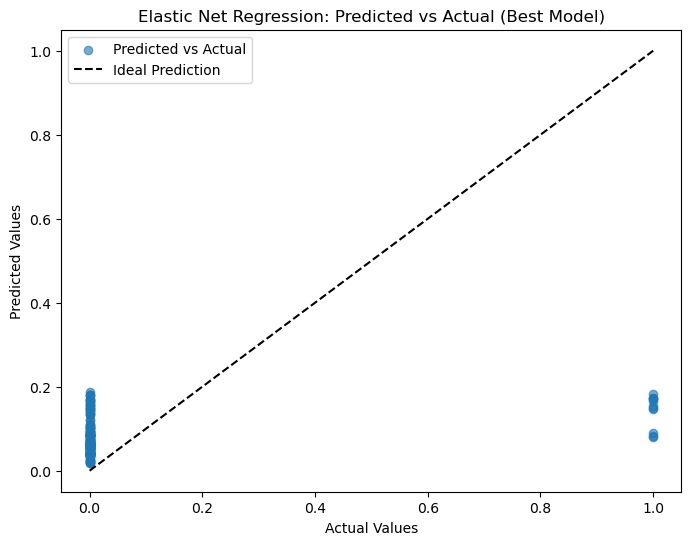

Best Parameters: {'softlabels': 'Binary', 'softlabel_thresholds': 65, 'softlabel_gradients': 0.8, 'rna-seq':                  NOC2L  PLEKHN1      HES4     ISG15       AGRN    RNF223  \
deconvo                                                                    
TCGA-A1-A0SB  2313.860   32.292   121.264    25.136   9276.024    36.484   
TCGA-A1-A0SD  2270.804  195.848   177.600  3478.232   7527.404    65.616   
TCGA-A1-A0SE  3380.752  150.696    68.580   320.296  11528.724   186.432   
TCGA-A1-A0SF  4120.980  343.252    54.152   301.516  10883.852   146.044   
TCGA-A1-A0SG  5420.084  408.852   261.284  2210.040  21232.732   257.616   
...                ...      ...       ...       ...        ...       ...   
TCGA-OL-A6VR  7219.260  503.968   416.080  3813.168  12927.488   223.296   
TCGA-PE-A5DC  3238.472   81.540   325.040  4357.596   7780.216   395.696   
TCGA-PE-A5DD  2831.028  105.652   307.956   951.340  10387.860    95.368   
TCGA-PE-A5DE  2204.604  211.856   220.588  1032.412   5

: 

In [9]:
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

def train_model(params, metadata, best_metrics):
    features_df = params['rna-seq']
    metadata_truncated = metadata.loc[metadata.index.intersection(features_df.index)]
    
    labels_df = metadata_truncated['HRD-sum'].sort_index()
    features_df = features_df.sort_index()
    
    if params['normalization'] == 'StandardScaler':
        scaler = StandardScaler()
        features_df = pd.DataFrame(scaler.fit_transform(features_df), index=features_df.index, columns=features_df.columns)
    elif params['normalization'] == 'log2':
        features_df = np.log2(features_df + 1)

    # Apply soft labels
    if params['softlabels'] == "Sigmoid":
        labels_df = sigmoid_transform(labels_df, params['softlabel_thresholds'], params['softlabel_gradients'])
    elif params['softlabels'] == "Binary":
        labels_df = binary_hrd(labels_df, params['softlabel_thresholds'])

    # Downsample LumA samples
    removed_samples = None
    if params['downsample'][0]:
        df_downsampled, removed_samples = downsampling_lumA(metadata_truncated, params['downsample_thresholds'])
        features_df = features_df.loc[features_df.index.intersection(df_downsampled.index)]
        labels_df = df_downsampled.loc[df_downsampled.index.intersection(features_df.index), 'HRD-sum']
    
    labels = labels_df.squeeze()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)
    
    if params['downsample'][1] and removed_samples is not None:
        X_test, y_test = add_back_test(features_df, removed_samples, X_test, y_test)

    # Train model
    model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, model, params, X_train, X_test, y_test, y_pred


# Parallel execution
num_cores = -1  # Use all available cores
results = Parallel(n_jobs=num_cores)(
    delayed(train_model)(params, metadata, {'Mean Squared Error': float('inf'), 'R^2 Score': -float('inf')}) for params in random_params
)

# Extract best model
best_metrics = {'Mean Squared Error': float('inf'), 'R^2 Score': -float('inf')}
best_model = None
best_params = None
best_X_train, best_X_test, best_y_test, best_y_pred = None, None, None, None

for mse, r2, model, params, X_train, X_test, y_test, y_pred in results:
    if mse < best_metrics['Mean Squared Error'] or (mse == best_metrics['Mean Squared Error'] and r2 > best_metrics['R^2 Score']):
        best_model = model
        best_metrics = {'Mean Squared Error': mse, 'R^2 Score': r2}
        best_params = params
        best_X_train, best_X_test, best_y_test, best_y_pred = X_train, X_test, y_test, y_pred

# Save best model
joblib.dump(best_model, 'model.joblib')

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(best_y_test, best_y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([min(best_y_test), max(best_y_test)], [min(best_y_test), max(best_y_test)], 'k--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Elastic Net Regression: Predicted vs Actual (Best Model)')
plt.legend(loc="upper left")
plt.show()

print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error: {best_metrics['Mean Squared Error']:.3f}")
print(f"R^2 Score: {best_metrics['R^2 Score']:.3f}")


In [1]:
1000/(12*60)

1.3888888888888888

In [5]:
import numpy as np
alphas = [0.01, 0.1, 0.25, 0.5, 1.0]
l1_ratios = [0.1, 0.5, 0.7, 0.9]
rna_seqs = [1, 2, 3]
downsample = [(True, False),(True,False), (False,False)]
downsample_thresholds = [x for x in range(10, 80, 5)]
softlabels = ["None", "Sigmoid", "Binary"]
softlabel_thresholds = [x for x in range(10, 80, 5)]
softlabel_gradients = np.arange(0, 1, 0.1)
normalization = ['StandardScaler','log2','None']

In [6]:
len(alphas)*len(l1_ratios)*len(rna_seqs)*len(downsample)*len(downsample_thresholds)*len(softlabels)*len(softlabel_thresholds)*len(softlabel_gradients)*len(normalization)

3175200

In [11]:
3175200/(len(downsample)*len(downsample_thresholds)*len(softlabels)*len(normalization))

8400.0

In [10]:
5000/3175200.0*100

0.15747039556563366